**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

In [1]:
# import sys
import re
import gzip
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# # загружаем предварительно очищенный текст
# with gzip.open('../data/text.txt.gz','rt',encoding='utf-8') as f: text = f.read()

In [3]:
# загружаем текст
with gzip.open('../data/dostoevsky-besy-p3.txt.gz','rt',encoding='utf-8') as f: 
    text = [ s.strip() for s in re.split(r'[\n.?!]',f.read()) if s.strip() ]

In [4]:
len(text)

5708

In [5]:
# убираем заголовок
text = text[7:]

---

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

In [7]:
# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е',] # замена ё для унификации
       ,[r'[^а-я ]+',' '] # оставляем только буквы и пробел
       ,[r'^- *',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [8]:
text = list(map(string_normalizer,text))

In [9]:
text[:5]

['праздник состоялся несмотря ни на какие недоумения прошедшего шпигулинского дня',
 'я думаю что если бы даже лембке умер в ту самую ночь то праздник все таки бы состоялся на утро до того много соединяла с ним какого то особенного значения юлия михайловна',
 'увы она до последней минуты находилась в ослеплении и не понимала настроения общества',
 'никто под конец не верил что торжественный день пройдет без какого нибудь колоссального приключения без развязки как выражались иные заранее потирая руки',
 'многие правда старались принять самый нахмуренный и политический вид но вообще говоря непомерно веселит русского человека всякая общественная скандальная суматоха']

In [10]:
# разрезаем текст на слова
text = [ [ w.strip() for w in s.split() if w.strip() ] for s in text ]

In [11]:
# text[:2]

In [12]:
context_deep = 2 # глубина контекста

In [13]:
# удаляем короткие словосочетания
text = [ s for s in text if len(s) > context_deep*2 ]
len(text)

4223

In [14]:
text

[['праздник',
  'состоялся',
  'несмотря',
  'ни',
  'на',
  'какие',
  'недоумения',
  'прошедшего',
  'шпигулинского',
  'дня'],
 ['я',
  'думаю',
  'что',
  'если',
  'бы',
  'даже',
  'лембке',
  'умер',
  'в',
  'ту',
  'самую',
  'ночь',
  'то',
  'праздник',
  'все',
  'таки',
  'бы',
  'состоялся',
  'на',
  'утро',
  'до',
  'того',
  'много',
  'соединяла',
  'с',
  'ним',
  'какого',
  'то',
  'особенного',
  'значения',
  'юлия',
  'михайловна'],
 ['увы',
  'она',
  'до',
  'последней',
  'минуты',
  'находилась',
  'в',
  'ослеплении',
  'и',
  'не',
  'понимала',
  'настроения',
  'общества'],
 ['никто',
  'под',
  'конец',
  'не',
  'верил',
  'что',
  'торжественный',
  'день',
  'пройдет',
  'без',
  'какого',
  'нибудь',
  'колоссального',
  'приключения',
  'без',
  'развязки',
  'как',
  'выражались',
  'иные',
  'заранее',
  'потирая',
  'руки'],
 ['многие',
  'правда',
  'старались',
  'принять',
  'самый',
  'нахмуренный',
  'и',
  'политический',
  'вид',
  'но'

---

In [15]:
# ограничиваем количество примеров, чтобы поместиться в память
n_samples = 100

i_samples = np.random.permutation(len(text))[:n_samples]

text = [ text[i] for i in i_samples ]

---

In [16]:
# заменяем слова в тексте их номерами в словаре
words = sorted(set(sum(text,[]))) # словарь из текста
vocab =  { w:i for i,w in enumerate(words) }
code = [ [ vocab[w] for w in s ] for s in text ]

In [17]:
n_words = len(words) # количество слов в словаре
print( "размер словаря: %i слов" % n_words )

размер словаря: 782 слов


In [18]:
# [ контекст, слово, контекст]
def pack_history(s,cd=context_deep):
    return [ [ s[i-cd:i], s[i], s[i+1:i+cd+1] ] for i in range(cd,len(s)-cd) ] 

In [19]:
context = sum( [ pack_history(s,cd=context_deep) for s in code ], [] )

In [20]:
W = [ c[1] for c in context ] # коды слов
C = [ c[0]+c[2] for c in context ] # коды контекста слов

In [21]:
assert len(C) == len(W)

In [22]:
n_words,len(W)

(782, 1016)

In [23]:
# # ограничиваем количество примеров, чтобы поместиться в память

# n_samples = 15000

# i_samples = np.random.permutation(len(W))[:n_samples]
# W = [ W[i] for i in i_samples ]
# C = [ C[i] for i in i_samples ]

---

In [24]:
len(W), len(C)

(1016, 1016)

---

In [25]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)

Wbin = np.vstack([ E[c] for c in W ])
Wbin.shape

(1016, 782)

In [26]:
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 
Cbin.shape

(1016, 4, 782)

---

In [27]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [28]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [29]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [30]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

---

In [31]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

---

In [32]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = np.random.normal(scale=0.01,size=(n,k))
Vo = np.random.normal(scale=0.01,size=(k,n))

In [33]:
%%time

a = 0.91 # скорость обучения

er = [1e10]

n_steps = 100

for i in range(n_steps):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

1 6.66184815361714
2 6.657240781113791
3 6.643959009580712
4 6.614530114990197
5 6.567382827154412
6 6.501834355072686
7 6.41796676730969
8 6.316873959497657
9 6.202116599123671
10 6.085023746100623
11 5.9736124334175456
12 5.849282943115896
13 5.724808796371845
14 5.59123411497849
15 5.456950923951022
16 5.315897269856502
17 5.175016479153715
18 5.029834852830741
19 4.886119817222609
20 4.739053542874268
21 4.593455022248775
22 4.444243058803289
23 4.2962797445712395
24 4.144547418769375
25 3.994875800454647
26 3.841038151426749
27 3.6917838745809757
28 3.5355940452543124
29 3.3913616359411356
30 3.228286019468611
31 3.107866540024798
32 2.9233616128683226
33 2.9063428361899537
34 2.702726441980878
35 2.6786039430829187
36 2.478809057464882
37 2.4767052311251105
38 2.2760883841419615
39 2.2568780267374167
40 2.060619926633683
41 2.0664331642305775
CPU times: user 1min 10s, sys: 59.1 ms, total: 1min 10s
Wall time: 1min 10s


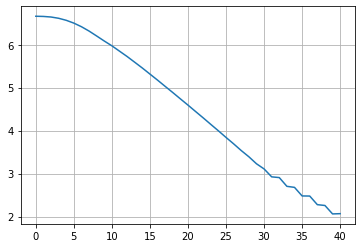

In [34]:
er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

---

In [35]:
from sklearn.metrics.pairwise import pairwise_distances

In [36]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [38]:
vocab = { i:w for i,w in enumerate(words) } # нумеруем слов в словаре

nn = np.random.permutation(len(words))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab[i] : [ vocab[j] for j in  R[i,1:3]  ] for i in nn }

{'состоится': ['конечно', 'бал'],
 'волнения': ['описывать', 'виргинский'],
 'печатных': ['листа', 'липутину'],
 'лямшин': ['вечер', 'чуткости'],
 'или': ['отчасти', 'нет'],
 'крышу': ['под', 'надлежащего'],
 'общее': ['пригорюнясь', 'пострадать'],
 'степанович': ['осилил', 'новых'],
 'часов': ['кучке', 'часу'],
 'вас': ['для', 'завтра'],
 'слишком': ['милости', 'была'],
 'крикнул': ['попа', 'прочтет'],
 'видеть': ['свое', 'будто'],
 'наготове': ['кармазинове', 'беспокойством'],
 'помещался': ['этою', 'подыматься'],
 'выполнено': ['планете', 'несмотря'],
 'тебя': ['люблю', 'взрывов'],
 'началом': ['фунтов', 'центру'],
 'страдал': ['заявите', 'тесно'],
 'отчаянная': ['новая', 'кончив']}